In [1]:
from operator import le
import streamlit as st
import torch
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from dotenv import load_dotenv
import os
from langchain.embeddings import CacheBackedEmbeddings
from langchain.storage import LocalFileStore
from pydantic import BaseModel
from semantic_router import SemanticRouter, Route
from semantic_router.sample import chatbotSample, chitchatSample
from langgraph.graph import START, StateGraph


d:\App\Anaconda\envs\psang\Lib\importlib\__init__.py:126: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  return _bootstrap._gcd_import(name[level:], package, level)


In [2]:
store = LocalFileStore("./cache/")

# Load environment variables
load_dotenv()
QDRANT_URL = os.getenv("QDRANT_URL")
QDRANT_API_KEY = os.getenv("QDRANT_API_Key")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Initialize embedding model --- #

In [3]:
def get_embeddings():
    embeddings = HuggingFaceEmbeddings(
        model_name='hiieu/halong_embedding',
        model_kwargs={'device': 'cpu'},
        encode_kwargs={'normalize_embeddings': False}
    )
    embedder = CacheBackedEmbeddings.from_bytes_store(embeddings,
                                                      store,
                                                      namespace="hiieu/halong_embedding")
    return embedder

embedding = get_embeddings()

C:\Users\DELL\AppData\Local\Temp\ipykernel_5876\3803639110.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(
d:\App\Anaconda\envs\psang\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
d:\App\Anaconda\envs\psang\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force

# --- Initialize Qdrant client and vector store --- #

In [4]:
def get_vectorstore():
    client = QdrantClient(
        url=QDRANT_URL,
        api_key=QDRANT_API_KEY,
    )
    
    return QdrantVectorStore(
    client=client, 
    collection_name="qa_tvpl",
    embedding=embedding
)

# --- Initialize LLM --- #


In [5]:
def get_llm():
    return ChatGroq(
        temperature=0,
        groq_api_key=GROQ_API_KEY,
        model_name="llama-3.1-8b-instant"
    )

# --- Create prompt template --- #


In [6]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            Bạn là một trợ lý ảo nhiệt tình và thành thật tư vấn về luật pháp.
            Bạn sẽ dựa trên các thông tin được cung cấp để trả lời các câu hỏi của người dùng.
            Tuyệt đối không được bịa ra câu trả lời, nếu không biết bạn phải trả lời không biết.
            Không trả lời các câu hỏi vô nghĩa, không liên quan.
            Dựa vào thông tin sau trả lời câu hỏi:
            {context}
            """,
        ),
        ("human", "{input}"),
    ]
)

# Initialize components


In [7]:
vector_store = get_vectorstore()
llm = get_llm()

LEGAL_ROUTE_NAME = 'legal'
CHITCHAT_ROUTE_NAME = 'normal'

legalRoute = Route(name=LEGAL_ROUTE_NAME, samples=chatbotSample)
chitchatRoute = Route(name=CHITCHAT_ROUTE_NAME, samples=chitchatSample)
semanticRouter = SemanticRouter(embedding, routes=[legalRoute, chitchatRoute])

# User query

In [8]:
user_question = "Quay phim khiêu dâm có bị phạt không?"

# Use normal rag

In [9]:
if user_question:
    guidedRoute = semanticRouter.guide(user_question)[1]

    if guidedRoute == LEGAL_ROUTE_NAME:        
        docs = vector_store.similarity_search(user_question, k=5)
        context = "\n\n".join([doc.page_content for doc in docs])
        
        messages = prompt.invoke({"input": user_question, "context": context})
        response = llm.invoke(messages)

    elif guidedRoute == CHITCHAT_ROUTE_NAME:
        messages = prompt.invoke({"input": user_question, "context": ""})
        response = llm.invoke(messages)
    


In [10]:
print(response.content)

Quay phim khiêu dâm có thể bị phạt tùy thuộc vào quy định pháp luật của từng quốc gia hoặc vùng lãnh thổ. Tuy nhiên, dựa trên thông tin bạn cung cấp, tôi sẽ trả lời dựa trên quy định pháp luật của Việt Nam.

Theo Điều 326 Bộ luật Hình sự 2015 được sửa đổi bởi khoản 124 Điều 1 Luật sửa đổi Bộ luật Hình sự 2017, có quy định về tội truyền bá văn hóa phẩm đồi trụy như sau:

Tội truyền bá văn hóa phẩm đồi trụy

1. Người nào làm ra, sao chép, lưu hành, vận chuyển, mua bán, tàng trữ nhằm phổ biến sách, báo, tranh, ảnh, phim, nhạc hoặc những vật phẩm khác có nội dung khiêu dâm, đồi trụy hoặc hành vi khác truyền bá vật phẩm đồi trụy thuộc một trong các trường hợp sau đây, thì bị phạt tiền từ 10.000.000 đồng đến 100.000.000 đồng, phạt cải tạo không giam giữ đến 03 năm hoặc phạt tù từ 06 tháng đến 03 năm:

a) Dữ liệu được số hóa có dung lượng từ 01 gigabyte (GB) đến dưới 05 gigabyte (GB);

b) Ảnh có số lượng từ 100 ảnh đến dưới 200 ảnh;

c) Sách in, báo in hoặc vật phẩm khác có số lượng từ 50 đơn

# LangGraph

In [88]:
from pydantic import BaseModel, Field
from typing import Literal

## Handle route

In [89]:
class RouterQuery(BaseModel):
    datasource: Literal["vectorstore", "normal_response"] = Field(
        ...,
        description="Dựa vào câu hỏi bạn hãy trả lời là nên sử dụng RAG với VectorStore hay không.",
    )

In [90]:
structured_llm_router = llm.with_structured_output(RouterQuery)

In [91]:
system = """
Bạn là chuyên gia trong việc định tuyến câu hỏi của người dùng đến vectorstore chứa các tài liệu liên quan đến tác nhân hoặc không, 
VectorStore bao gồm các tài liệu liên qua đến pháp luật, các vấn đề pháp luật và các trường hợp cần sử dụng đến pháp luật.
Sử dụng vectorstore cho các câu hỏi về các chủ đề này. Nếu không, hãy truyền thẳng câu hỏi đến llm để trả lời.
"""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router

In [92]:
question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": "Bạn là ai?"}
    )
)
print(question_router.invoke({"question": user_question}))

datasource='normal_response'
datasource='vectorstore'


## Retrieval Grader

In [93]:
retriever = vector_store.as_retriever(search_type="similarity")

In [94]:
# Data model
class GradeDocuments(BaseModel):
    binary_score: str = Field(
        description="Các Documents có liên qua đến câu hỏi của người dùng không , 'yes' hoặc 'no'"
    )

In [95]:
structured_llm_grader = llm.with_structured_output(GradeDocuments)

system = """
Bạn là người chấm điểm đánh giá mức độ liên quan của một tài liệu đã truy xuất đến câu hỏi của người dùng. \n 
Nếu tài liệu chứa từ khóa hoặc ý nghĩa ngữ nghĩa liên quan đến câu hỏi của người dùng, hãy chấm điểm là có liên quan. \n 
Không cần phải là một bài kiểm tra nghiêm ngặt. Mục tiêu là lọc ra các truy xuất sai. \n 
Đưa ra điểm nhị phân 'yes' hoặc 'no' để chỉ ra liệu tài liệu có liên quan đến câu hỏi hay không."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

In [131]:
retrieval_grader = grade_prompt | structured_llm_grader
docs = retriever.get_relevant_documents(user_question)
doc_txt = docs[0].page_content + docs[1].page_content
print(retrieval_grader.invoke({"question": user_question, "document": doc_txt}))

binary_score='yes'


In [97]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()
generation = rag_chain.invoke({"context": docs, "question": user_question})
print(generation)

d:\App\Anaconda\envs\psang\Lib\site-packages\langsmith\client.py:261: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Quay phim khiêu dâm có thể bị phạt từ 10.000.000 đồng đến 20.000.000 đồng đối với tổ chức và từ 5.000.000 đồng đến 10.000.000 đồng đối với cá nhân có hành vi vi phạm.


## Hallucination Grader

In [98]:
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Câu trả lời có liên quan đến các documents, 'yes' or 'no'"
    )

structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """
Bạn là người chấm điểm đánh giá LLM có generate dựa trên một tập hợp các documents đã thu thập được hay không. \n
Đưa ra điểm nhị phân 'yes' hoặc 'no'. 'yes' có nghĩa là câu trả lời dựa trên bởi tập hợp các documents.
"""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Tập hợp các documents: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

## Answer Grader

err

In [99]:
class GradeAnswer(BaseModel):
    binary_score: str = Field(
        description="Câu trả lời có cung cấp được nội dung cần tìm của câu hỏi, 'yes' or 'no'"
    )

structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """
Bạn là người chấm điểm đánh giá xem câu trả lời có giải quyết được câu hỏi hay không \n
Cho điểm nhị phân 'yes' hoặc 'no'. 'yes' có nghĩa là câu trả lời trả lời được vấn đề của câu hỏi.
"""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": user_question, "generation": generation})

GradeAnswer(binary_score='yes')

In [100]:
print("Câu hỏi: ", user_question)
print("Câu trả lời: ",generation)

Câu hỏi:  Quay phim khiêu dâm có bị phạt không?
Câu trả lời:  Quay phim khiêu dâm có thể bị phạt từ 10.000.000 đồng đến 20.000.000 đồng đối với tổ chức và từ 5.000.000 đồng đến 10.000.000 đồng đối với cá nhân có hành vi vi phạm.


## Re-write

In [101]:
### 
# Re-writer

# Prompt
system = """
Bạn là người viết lại câu hỏi, chuyển đổi câu hỏi đầu vào thành phiên bản tốt hơn được tối ưu hóa để truy xuất cửa hàng vector. Nhìn vào thông tin đầu vào và cố gắng suy luận về ngữ nghĩa cơ bản.
"""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
print(question_rewriter.invoke({"question": user_question}))

Câu hỏi được cải thiện:

"Phạt tiền hoặc hình phạt gì khi quay phim khiêu dâm?"

Câu hỏi này được cải thiện bằng cách:

- Thêm cụm từ "hình phạt gì" để làm rõ câu hỏi và yêu cầu người trả lời cung cấp thông tin cụ thể hơn về hình phạt có thể áp dụng.
- Sử dụng từ "phạt tiền" để làm rõ hơn về hình phạt có thể áp dụng.
- Câu hỏi này cũng có thể được cải thiện thêm bằng cách thêm thông tin về địa điểm hoặc quy định cụ thể (ví dụ: "Phạt tiền hoặc hình phạt gì khi quay phim khiêu dâm ở Việt Nam?").


In [102]:
from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
    question: str
    generation: str
    documents: List[str]

# Graph Flow

In [140]:
from langchain.schema import Document

In [141]:
def retrieve(state):
    
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [142]:
def generate(state):
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

In [143]:
def normal_response(state):
    print("---NORMAL RESPONSE---")
    question = state["question"]
    return {"question": question}

In [144]:
def grade_documents(state):
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}

In [145]:
def transform_query(state):
    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


In [146]:
def route_question(state):
    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "normal_response":
        print("---ROUTE QUESTION TO Normal Response---")
        return "normal_response"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [147]:
def decide_to_generate(state):
    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


In [148]:
def grade_generation_v_documents_and_question(state):
    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

# Compile Graph

In [149]:
from langgraph.graph import END, StateGraph, START

In [150]:
workflow = StateGraph(GraphState)
# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)
workflow.add_node("normal_response", normal_response)  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "normal_response": "normal_response",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("normal_response", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

In [151]:
from pprint import pprint

# Run
inputs = {
    "question": "Tấn công mạng bị phạt gì?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION DOES NOT ADDRESS QUESTION---
"Node 'generate':"
'\n---\n'
---TRANSFOR

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': "binary_score='no'</function>"}}

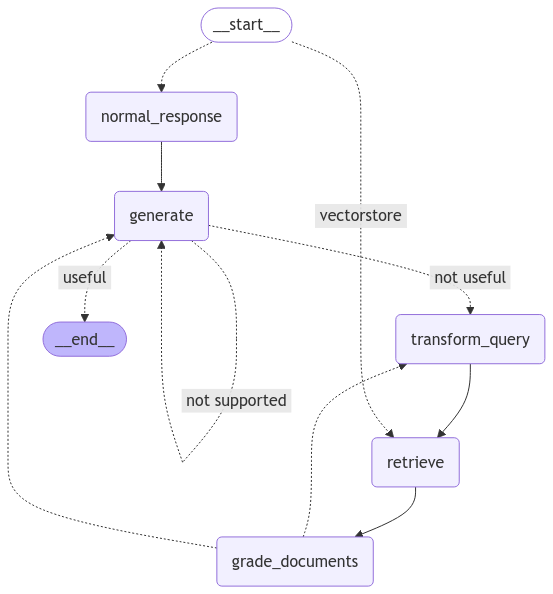

In [153]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [154]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}


### Edges ###


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [155]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

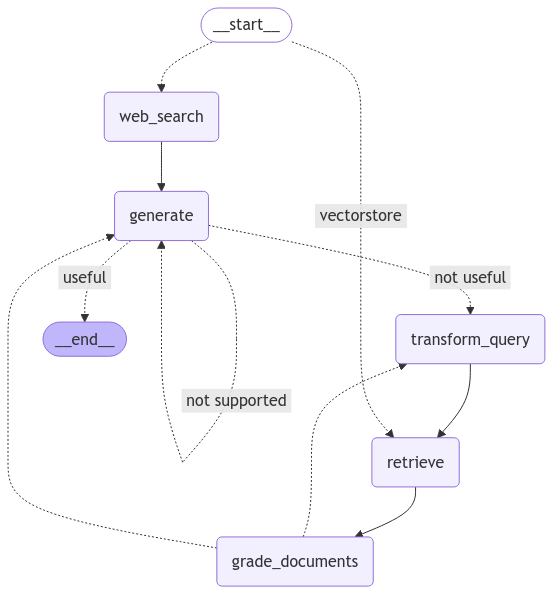

In [156]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))